# Reading Data:

In [34]:
import mne, os
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.preprocessing import ICA
from time import time

%matplotlib widget
mne.set_log_level('WARNING')
PLOT = True

In [35]:
folder_path = "D:\\Download\\Compressed\\files"
subjects = [4]


classes = {
    0 : "T0",
    1 : "T1",
    2 : "T2"
}
raw_subjects = []

for subject_num in subjects:
    subject_path = os.path.join(folder_path, f"S{subject_num:03}")
    files = [os.path.join(subject_path, f"S{subject_num:03}R{task_num:02}.edf") for task_num in range(3, 15)]
    raw_files = []

    for file in files:
        if not os.path.exists(file):
            raise Exception(f"Error: The file: {file} doesn't exist!")

        raw = mne.io.read_raw_edf(file, preload=True, stim_channel='auto')
        raw_files.append(raw)

    raw_subjects.append(mne.io.concatenate_raws(raw_files))

raw = mne.io.concatenate_raws(raw_subjects)

In [36]:
events, event_dict = mne.events_from_annotations(raw)
print(raw.info)
print(event_dict)

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


In [37]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
print (picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


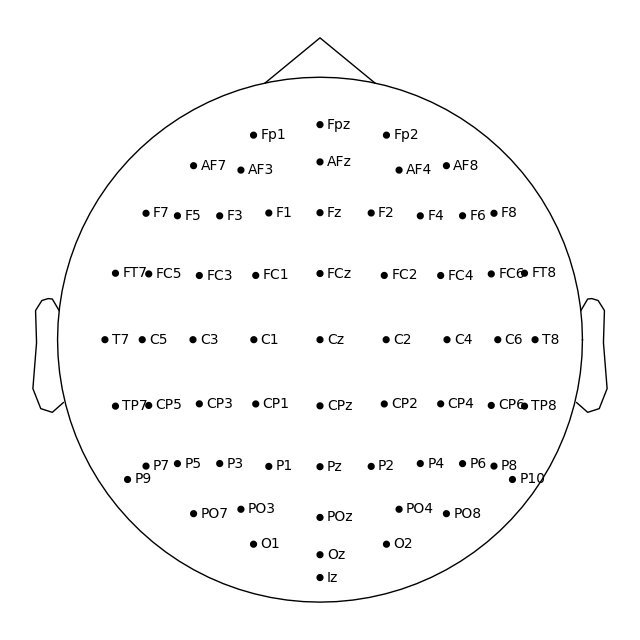

In [38]:
if PLOT:
    biosemi_montage = mne.channels.make_standard_montage('biosemi64')
    biosemi_montage.plot(show=False)
    plt.show()

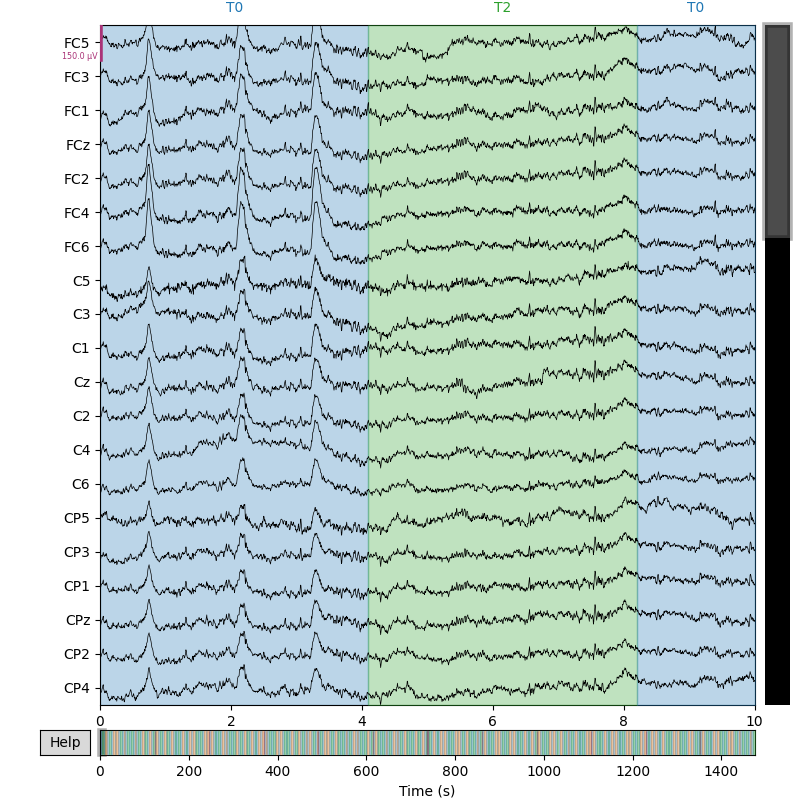

In [39]:
eegbci.standardize(raw)  # set channel names
if PLOT:
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)
    mne.viz.plot_raw(raw, scalings={"eeg": 75e-6}, show=False)
    plt.show()

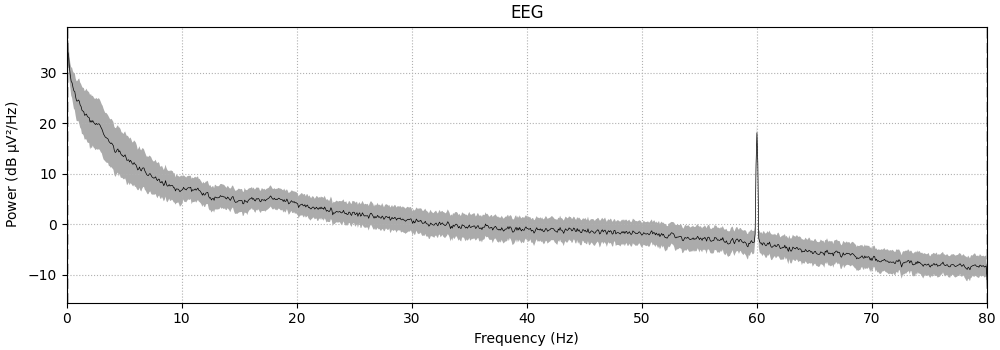

In [40]:
if PLOT:
    raw.plot_psd(average=True, show=False)
    plt.show()

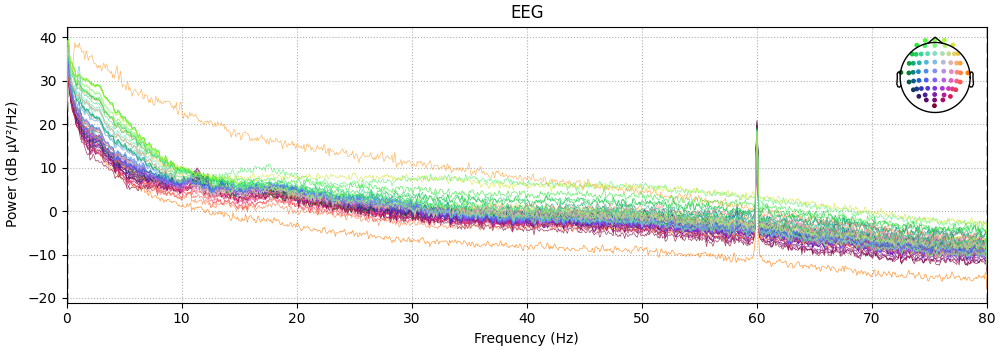

In [41]:
if PLOT:
    raw.plot_psd(average=False, show=False)
    plt.show()

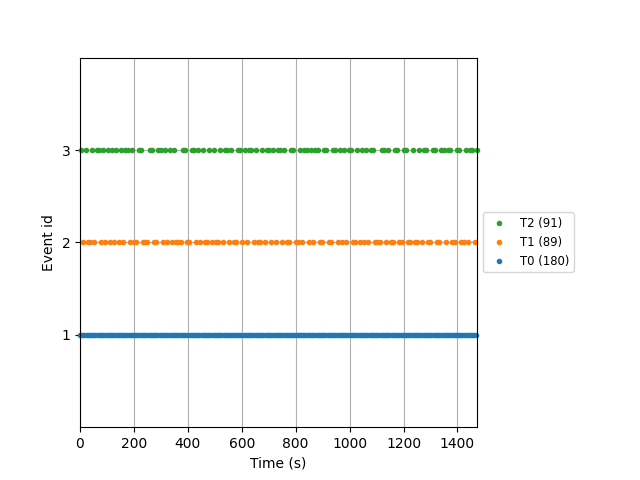

In [42]:
if PLOT:
    fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)

# Preprocessing the Data:

- filtring noise:

In [43]:
filtred_data = raw.filter(5., 40., fir_design='firwin', skip_by_annotation='edge')

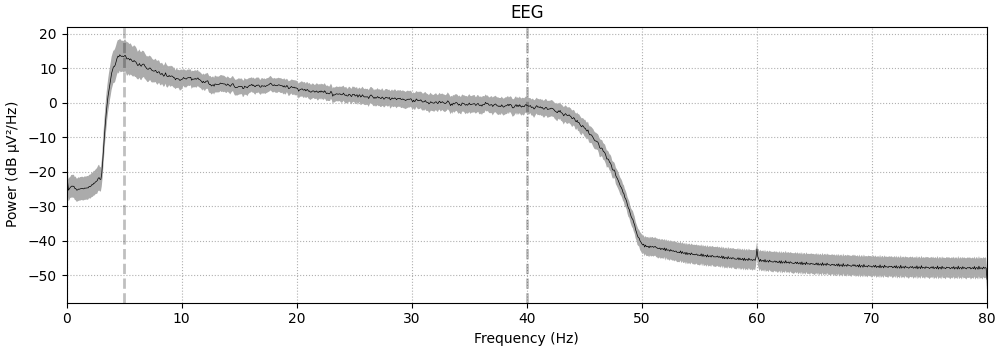

In [44]:
if PLOT:
    filtred_data.plot_psd(average=True, show=False)
    plt.show()

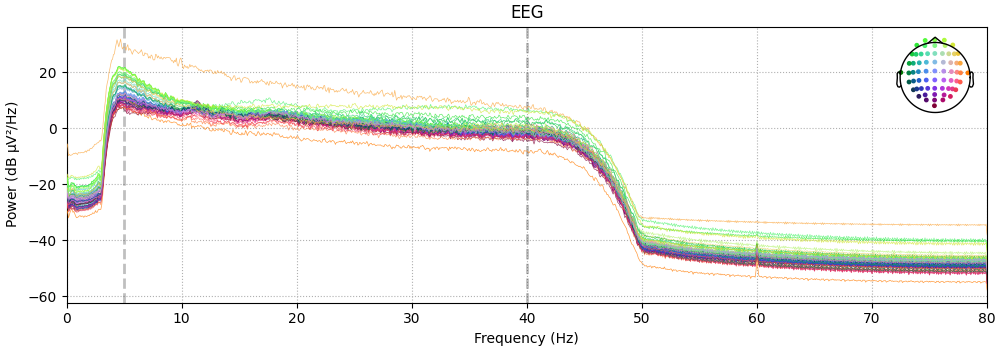

In [45]:
if PLOT:
    filtred_data.plot_psd(average=False, show=False)
    plt.show()

- Removing using ICA blinks and muscles movements

In [46]:
raw_corrected = filtred_data.copy()
n_components = 20
ica = ICA(n_components=n_components, random_state=97)
t0 = time()
ica.fit(raw_corrected, picks=picks)

<ICA | raw data decomposition, method: fastica (fit in 51 iterations on 236160 samples), 20 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

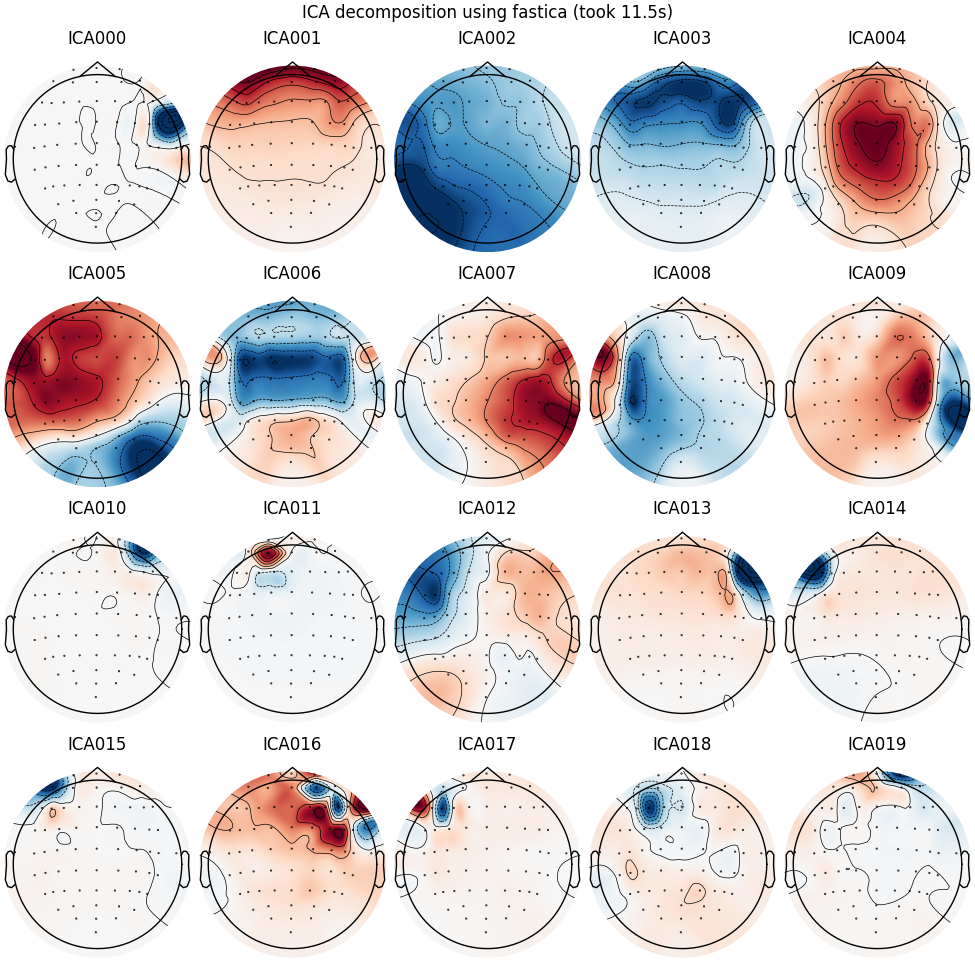

In [47]:
if PLOT:
    fit_time = time() - t0
    title = ('ICA decomposition using %s (took %.1fs)' % (ica.method, fit_time))
    ica.plot_components(title=title, show=False)
    plt.show()

d:\Projects\42\Total-perspective-vortex\TotalVortex-env\Lib\site-packages\mne\viz\ica.py:982: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(


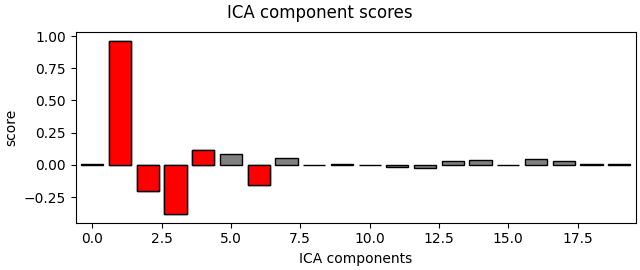

[np.int64(1), np.int64(3), np.int64(2), np.int64(6), np.int64(4)] {'eog/0/Fpz': [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6)], 'eog': [np.int64(1), np.int64(3), np.int64(2), np.int64(6), np.int64(4)]}


In [48]:
eog_indices, scores = ica.find_bads_eog(filtred_data, ch_name='Fpz',threshold=1.5)
if PLOT:
    ica.plot_scores(scores, exclude=eog_indices)  # look at r scores of components

ica.exclude.extend(eog_indices) 
raw_corrected = ica.apply(raw_corrected, n_pca_components = n_components, exclude = ica.exclude)
print(ica.exclude, ica.labels_)

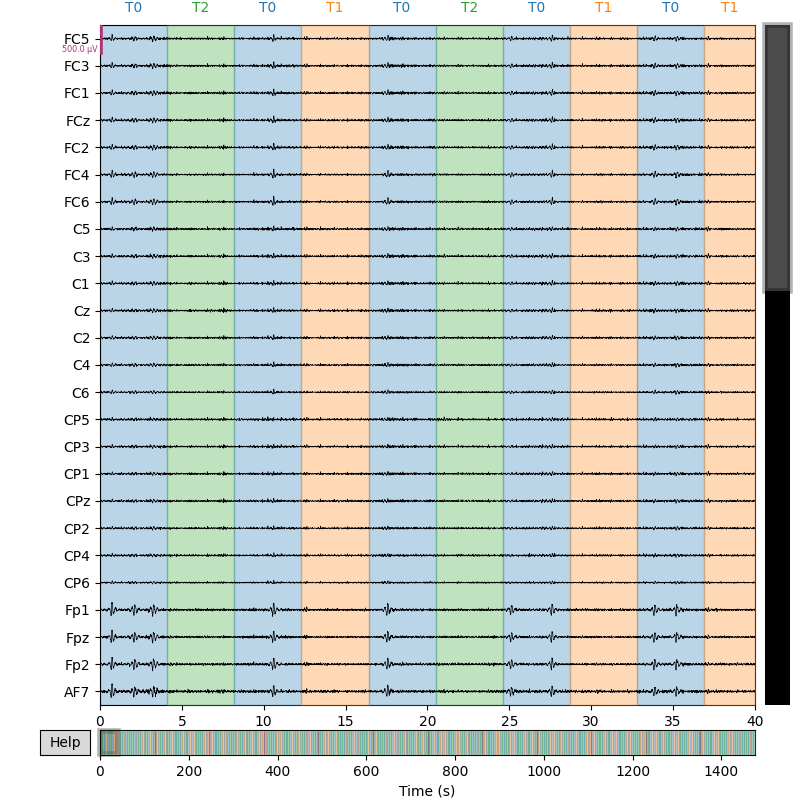

In [49]:
if PLOT:
    filtred_data.plot(n_channels=25, start=0, duration=40,scalings=dict(eeg=250e-6), show=False)
    plt.show()

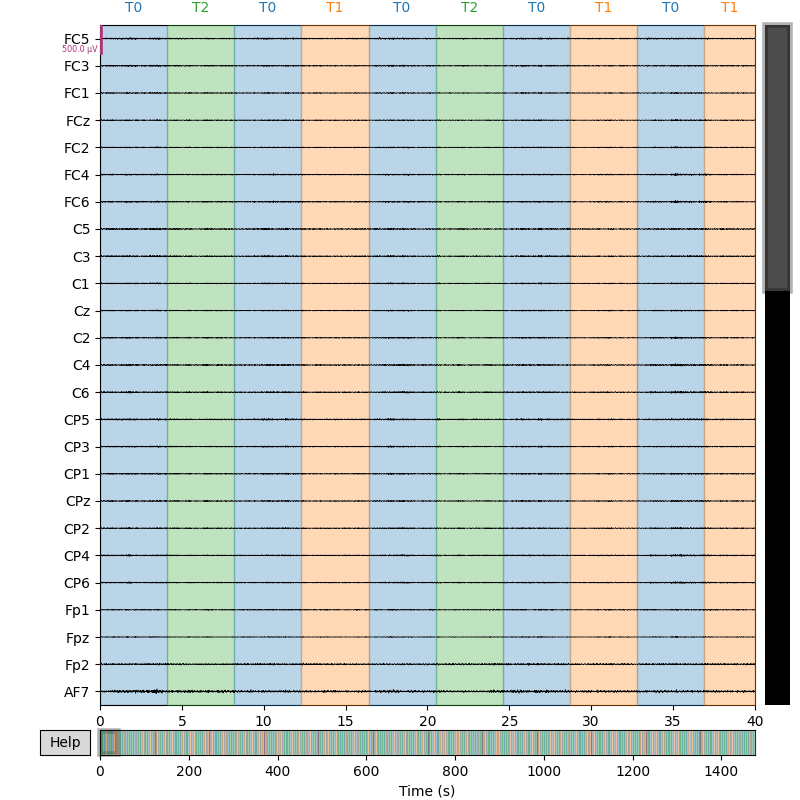

In [50]:
if PLOT:
    raw_corrected.plot(n_channels=25, start=0, duration=40,scalings=dict(eeg=250e-6), show=False)
    plt.show()

# Converting to EPOCHS:

In [51]:
event_ids = {classe:key for key, classe in classes.items()}

In [52]:
events, event_dict = mne.events_from_annotations(raw_corrected, event_id=event_ids)
epochs = mne.Epochs(filtred_data, events, event_ids, -1., 4., proj=True,
                    picks=picks, baseline=None, preload=True)

epochs

<Epochs | 348 events (all good), -1 – 4 s (baseline off), ~136.2 MB, data loaded,
 'T0': 168
 'T1': 89
 'T2': 91>

In [53]:
labels = epochs.events[:, -1]
labels

array([2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0,
       1, 0, 2, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1,
       0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 1, 0, 2, 0, 2, 0, 1, 0,
       1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 1,
       0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1,
       0, 1, 0, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0,
       2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 0, 1, 0, 2,
       0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2, 0,
       1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0,
       2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1,
       0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0,
       2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 1, 0, 2,
       0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2,
       0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2,

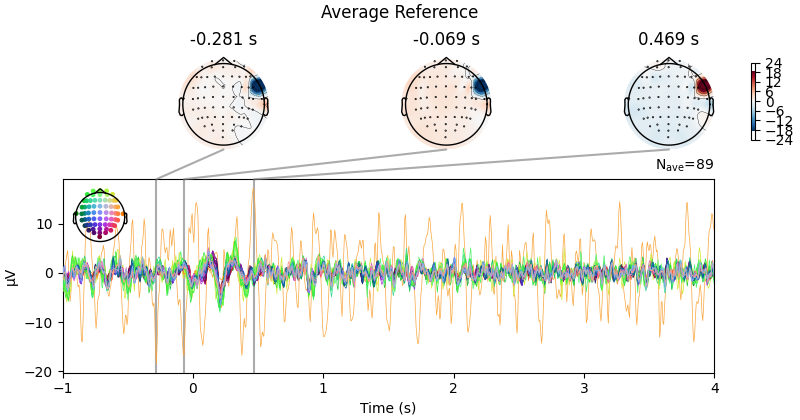

In [54]:
if PLOT:
    evoked = epochs["T1"].average()
    evoked.plot_joint(title='Average Reference', show=False)
    plt.show()

# Training phase:

In [55]:
if not PLOT:
    from mne.decoding import CSP
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import classification_report
    from sklearn.multiclass import OneVsRestClassifier
    import numpy as np

In [56]:
if not PLOT:
    best_model = None
    best_accuracy = 0
    means_score = []
    epochs_data = epochs.get_data()

### Classifiers:

- Logistique regression classifier:

In [57]:
if not PLOT:
    clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    pipeline = Pipeline([
                ('csp', csp),
                ('classifier', clf)
            ])
    cv = ShuffleSplit(10, test_size=0.4, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    print(scores)
    print(f"Mean accuracy of experiment 1: {scores.mean():.4f}")
    pipeline.fit(X_train, y_train)

    # Test Data
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = report['accuracy']
    means_score.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

    print(f"Accuracy: {accuracy}")

- MLP classifier:

In [58]:
if not PLOT:
    clf = OneVsRestClassifier(MLPClassifier(max_iter=2000))
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    pipeline = Pipeline([
                ('csp', csp),
                ('classifier', clf)
            ])
    cv = ShuffleSplit(10, test_size=0.4, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    print(scores)
    print(f"Mean accuracy of experiment 1: {scores.mean():.4f}")
    pipeline.fit(X_train, y_train)

    # Test Data
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = report['accuracy']
    means_score.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

    print(f"Accuracy: {accuracy}")

- SVC classifer:

In [59]:
if not PLOT:
    clf = OneVsRestClassifier(SVC(kernel='linear', probability=True))
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    pipeline = Pipeline([
                ('csp', csp),
                ('classifier', clf)
            ])
    cv = ShuffleSplit(10, test_size=0.4, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    print(scores)
    print(f"Mean accuracy of experiment 1: {scores.mean():.4f}")
    pipeline.fit(X_train, y_train)

    # Test Data
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = report['accuracy']
    means_score.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

    print(f"Accuracy: {accuracy}")

- RandomForest Classifier

In [60]:
if not PLOT:
    clf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    pipeline = Pipeline([
                ('csp', csp),
                ('classifier', clf)
            ])
    cv = ShuffleSplit(10, test_size=0.4, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    print(scores)
    print(f"Mean accuracy of experiment 1: {scores.mean():.4f}")
    pipeline.fit(X_train, y_train)

    # Test Data
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = report['accuracy']
    means_score.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

    print(f"Accuracy: {accuracy}")

- GradientBoosting Classifier

In [61]:
if not PLOT:
    clf = OneVsRestClassifier(GradientBoostingClassifier())
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    pipeline = Pipeline([
                ('csp', csp),
                ('classifier', clf)
            ])
    cv = ShuffleSplit(10, test_size=0.4, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    print(scores)
    print(f"Mean accuracy of experiment 1: {scores.mean():.4f}")
    pipeline.fit(X_train, y_train)

    # Test Data
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = report['accuracy']
    means_score.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

    print(f"Accuracy: {accuracy}")

- LogisticRegression liblinear classifer:

In [62]:
if not PLOT:
    clf = OneVsRestClassifier(LogisticRegression(penalty='l1', solver='liblinear'))
    csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
    pipeline = Pipeline([
                ('csp', csp),
                ('classifier', clf)
            ])
    cv = ShuffleSplit(10, test_size=0.4, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    print(scores)
    print(f"Mean accuracy of experiment 1: {scores.mean():.4f}")
    pipeline.fit(X_train, y_train)

    # Test Data
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = report['accuracy']
    means_score.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

    print(f"Accuracy: {accuracy}")

In [63]:
if not PLOT:

    print("Mean accuracy of the six different experiments for all subjects:")
    print(f"Mean accuracy of 6 experiments: {np.mean(means_score)}")

- Predict:

In [64]:
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
accuracy = report['accuracy']
print(accuracy)

NameError: name 'best_model' is not defined

In [ ]:
if not PLOT:
    print("X shape= ", X_test.shape, "y shape= ", y_test.shape)
    scores = []

    for i in range(X_test.shape[0]):
        pred = best_model.predict(X_test[i:i+1, :, :])
        print("pred= ", pred, "truth= ", y_test[i:i+1])
        scores.append(1 if pred == y_test[i:i+1] else 0)

    print("Mean acc= ", np.mean(scores))